In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

import sys
sys.path.append('./../')
sys.path.append('./../../designer/script')
sys.path.append('./../../')

from film import TwoMaterialFilm
from spectrum import SpectrumSimple
from optimizer.adam import AdamThicknessOptimizer
from utils.substitute import equal_optical_thickness, optimal_and_thin_film_approx_substitution_onestep_new
from utils.loss import calculate_RMS
from analyze_utils.result_io import save, load

In [3]:
rep = 500
thin_layer_nums = [5, 10, 20]
thin_thickness = 1.

layer_num = 40
layer_avg = 100
layer_var = 20



def exp_sub_and_gd(original_film: TwoMaterialFilm, sub_func, gd=True):
    to_change_film = copy.deepcopy(original_film)
    sub_func(to_change_film, thin_thickness + 1.)
    loss_after_sub = calculate_RMS(original_film, to_change_film)
    if not gd:
        return loss_after_sub
    optimizer = AdamThicknessOptimizer(
        to_change_film, 
        original_film.get_all_spec_list(), 
        max_steps=200, 
        alpha=0.1, 
        record=False, 
        show=False,
    )
    optimizer()
    loss_after_gd = calculate_RMS(original_film, to_change_film)

    return [loss_after_sub, loss_after_gd]

In [ ]:

losses_eqot_rep = []
losses_optim_rep = []

for i in range(rep):
    print(i / rep)
    losses_eqot_rep.append([])
    losses_optim_rep.append([])
    for thin_layer_num in thin_layer_nums:
        np.random.seed()

        d = np.random.random(layer_num) * layer_var + layer_avg
        # randomly select layers to set to thin.
        idx = np.arange(layer_num - 1) # except layer layer
        np.random.shuffle(idx)
        thin_idx = idx[:thin_layer_num]
        d[thin_idx] = thin_thickness

        film = TwoMaterialFilm(1.5, 2.5, 1.5, d)
        film.add_spec_param(inc_ang=60., wls=np.linspace(500, 1000, 500))

        losses_eqot_rep[-1].append(exp_sub_and_gd(film, equal_optical_thickness))
        losses_optim_rep[-1].append(exp_sub_and_gd(film, optimal_and_thin_film_approx_substitution_onestep_new))
save('./raw_result/after_gd_20layers_110+-20nm_thinlayer_5_10_20', losses_eqot_rep, losses_optim_rep)

In [4]:
losses_eqot_rep, losses_optim_rep = load('./raw_result/after_gd_20layers_110+-20nm_thinlayer_1_3_5')

(500, 3) 3
(500, 3) 3
(500, 3) 3
(500, 3) 3


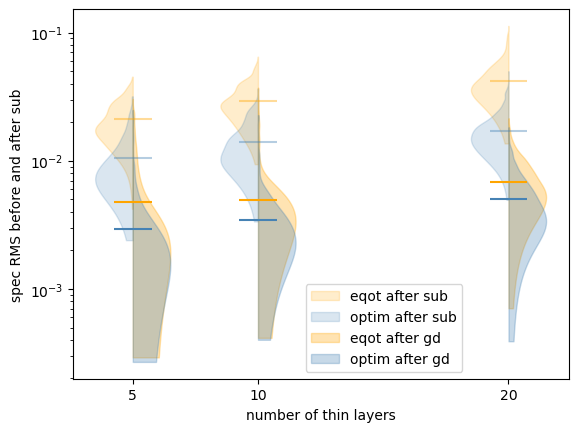

In [29]:
fig, ax = plt.subplots(1, 1)
eqot_after_sub = np.array(losses_eqot_rep)[:, :, 0]
eqot_after_gd = np.array(losses_eqot_rep)[:, :, 1]

optim_after_sub = np.array(losses_optim_rep)[:, :, 0]
optim_after_gd = np.array(losses_optim_rep)[:, :, 1]


def plot_rep_violin(ax, x, arr, label, c, alpha=0.5, zorder=None, left=False, right=False):
    print(arr.shape, len(x))
    arr_ls = [arr[:, i] for i in range(arr.shape[1])]
    s = ax.violinplot(
        arr_ls, 
        x, 
        widths=3, 
        showmedians=False,
        showmeans=True, 
        showextrema=False, 
        points=1000
    )

    # for partname in ('cbars','cmins','cmaxes', 'cmeans'):
    for partname in ('cmeans', ):
        vp = s[partname]
        vp.set_edgecolor(c)
        if alpha is not None:
            vp.set_alpha(alpha * 2)
        # vp.set_linewidth(1)



    for pc in s['bodies']:
        pc.set_facecolor(c)
        pc.set_edgecolor(c)
        if alpha is not None:
            pc.set_alpha(alpha)

        # get the center
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        if right:
            # modify the paths to not go further left than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        if left:
            # modify the paths to not go further left than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
    
    return mpatches.Patch(
        color=s['bodies'][0].get_facecolor().flatten(), 
        label=label
    )
labels = []
labels.append(plot_rep_violin(ax, thin_layer_nums, eqot_after_sub, label='eqot after sub', c='orange', alpha=0.2, left=True,))
labels.append(plot_rep_violin(ax, thin_layer_nums, optim_after_sub, label='optim after sub', c='steelblue', alpha=0.2, left=True,))

labels.append(plot_rep_violin(ax, thin_layer_nums, eqot_after_gd, label='eqot after gd', alpha=None, c='orange', right=True))
labels.append(plot_rep_violin(ax, thin_layer_nums, optim_after_gd, label='optim after gd', alpha=None, c='steelblue', right=True))

ax.set_xlabel('number of thin layers')
ax.set_ylabel('spec RMS before and after sub')
ax.set_xticks([5, 10, 20])

ax.set_yscale('log')
# ax.set_ylim(0, 1e-2)
ax.legend(handles=labels, loc='lower right', bbox_to_anchor=(0.8, 0))


fig.savefig('./figs/sub_and_GD_dif_number_log.png', dpi=300)

In [ ]:
def scan_layer_and_ot():
    rep = 20
    thin_layer_num = 20
    layer_nums = np.arange(10, 100, 20)
    layer_avgs = np.arange(10, 400, 20)
    losses_eqot_rep = []
    losses_optim_rep = []
    for _ in range(rep):
        losses_eqot_rep.append([])
        losses_optim_rep.append([])
        for layer_num in layer_nums:
            losses_eqot_rep[-1].append([])
            losses_optim_rep[-1].append([])
            for layer_avg in layer_avgs:
                np.random.seed()

                d = np.random.random(layer_num) * layer_var + layer_avg
                # randomly select layers to set to thin.
                idx = np.arange(layer_num - 1) # except layer layer
                np.random.shuffle(idx)
                thin_idx = idx[:thin_layer_num]
                d[thin_idx] = thin_thickness

                film = TwoMaterialFilm(1.5, 2.5, 1.5, d)
                film.add_spec_param(inc_ang=60., wls=np.linspace(500, 1000, 500))

                losses_eqot_rep[-1][-1].append(exp_sub_and_gd(film, equal_optical_thickness, gd=False))
                losses_optim_rep[-1][-1].append(exp_sub_and_gd(film, optimal_and_thin_film_approx_substitution_onestep_new, gd=False))
    return losses_eqot_rep, losses_optim_rep
losses_eqot_scan_rep, losses_optim_scan_rep = scan_layer_and_ot()

Text(0, 0.5, 'layer nums')

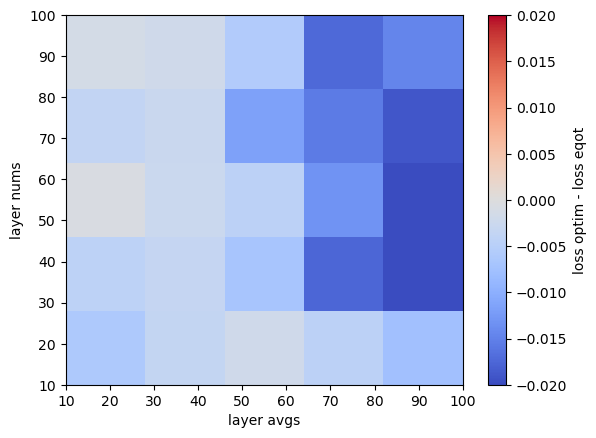

In [29]:
losses_eqot_scan = np.mean(np.array(losses_eqot_scan_rep), axis=0)
losses_optim_scan = np.mean(np.array(losses_optim_scan_rep), axis=0)

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    losses_optim_scan[:, :] - losses_eqot_scan[:, :], 
    cmap='coolwarm', 
    extent=[10, 100, 100, 10], 
    aspect='auto', 
    vmax=0.02, 
    vmin=-0.02
)

ax.invert_yaxis()
cbar = fig.colorbar(s)
cbar.set_label('loss optim - loss eqot')
ax.set_xlabel('layer avgs')
ax.set_ylabel('layer nums')